


# *Data Science Unit 4 Sprint 2 Assignment 4*

Continue to use TensorFlow Keras & a sample of the [Quickdraw dataset](https://github.com/googlecreativelab/quickdraw-dataset) to build a sketch classification model. The dataset has been sampled to only 10 classes and 10000 observations per class. Apply regularization techniques to your model. 

**Don't forget to switch to GPU on Colab!**


## Objectives 

In lecture, you were exposed to several regularization techniques: Lp space regularization, Max Norm weight constraints, and dropout regularization.

1: Explore the effects of these regularization techniques on model performance and on the learned model weights. 

2: Review how to save a model and how to retrieve the saved model from a file.





#### Import libraries

In [ ]:
# native libraries 
import os
from time import time 

# data analysis libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# deep learning libraries 
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import ReLU
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.utils import get_file



# regularizers 
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.constraints import MaxNorm

# required for compatibility between sklearn and keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# native python unit test library
from unittest import TestCase

%matplotlib inline

-----
# Part 1: GridSearch Experiments 

The next set of experiments will involve gridsearching regularization parameter values. 

The rest of the notebook will actually require very little coding on your part. Instead, the focus is for you to run those gridsearches and answer the questions at the end of each experiment. Those questions are designed to help you capture the insights that there are to learn from each of the experiments. 

All of the following experiments are designed to help you better understand the relationship between the various regularization techniques and how they affect model performance. 


### Build Model

Let's build out the model that we'll be using all throughout our experiments. 

Remember that **the whole point of regularization is to prevent overfitting.**


![](https://hackernoon.com/hn-images/1*vuZxFMi5fODz2OEcpG-S1g.png)

Overfitting happens when our models are too complex, so in order to see a benefit from the use of regularization techniques we need to build a relatively complex model. 

Having said that, you might not have the computational resource to be able to train a complex model in a reasonable amount of time. So if this describes you, then you might want to consider using `build_simple_model`. Otherwise, use `build_complex_model`. 

In this notebook, we'll use  `build_complex_model` to run our experiments. 

**NOTE:** Whichever function you end up using to build a model, take time to read through the code and make sure you understand what is happening. 

### Load the `quickdraw10` data set
using code provided in the Module 3 assignment.

In [ ]:
# YOUR CODE HERE
def load_quickdraw10():
    """
    Loads the Quickdraw-10 dataset and splits it into training and testing sets.

    The Quickdraw-10 dataset consists of drawings of 10 different classes:
    - apple
    - anvil
    - airplane
    - banana
    - The Eiffel Tower
    - The Mona Lisa
    - The Great Wall of China
    - alarm clock
    - ant
    - asparagus

    Returns
    -------
      A tuple of four Numpy arrays: (X_train, X_test, y_train, y_test)

      X_train : A 2D Numpy array of shape (num_train_samples, num_features) representing the
             training data, where each row corresponds to a drawing and each column
             corresponds to a feature.

      X_test: A 2D Numpy array of shape (num_test_samples, num_features) representing the
            testing data, where each row corresponds to a drawing and each column
            corresponds to a feature.
            
      y_train: A 1D Numpy array of shape (num_train_samples,) representing the labels
             of the training data.
             
      y_test: A 1D Numpy array of shape (num_test_samples,) representing the labels
            of the testing data.
    """
    
    URL_ = "https://github.com/LambdaSchool/DS-Unit-4-Sprint-2-Neural-Networks/blob/main/quickdraw10.npz?raw=true"
    
    path_to_zip = get_file('./quickdraw10.npz', origin=URL_, extract=False)

    data = np.load(path_to_zip)
    
    # normalize your image data
    max_pixel_value = 255
    X = data['arr_0']/max_pixel_value
    Y = data['arr_1']
        
    return train_test_split(X, Y, shuffle=True)

In [ ]:
X_train, X_test, y_train, y_test = load_quickdraw10()

25421363/25421363 [==============================] - 0s 0us/step


In [ ]:
X_train.shape

(75000, 784)

In [ ]:
y_train.shape

(75000,)

### Build the model

In [ ]:
def build_complex_model(Lp_reg=None, reg_penalty=None, dropout_prob=0.0, maxnorm_wc=None):
    """
    Build and return a regularized 3 hidden layer FCFF model 
    
    Parameters
    ----------
    Lp_reg: None or object
        If object, Lp_reg is either l1 or l2 regularization 
        If None, that means that l1 or l2 regularization will not be used.
     
    reg_penalty: None or float
        If float, reg_penalty is a value typically between 1.0 and 0.0001
        This is the regularization strength for l1 or l2 
        
        
    dropout_prob: float
        This is the probability that dropout regularization will exclude a node from a training iteration. 
        If this value is 0.0, that means that dropout will not be used. 
        
    maxnorm_wc: None or float
        If float, maxnorm_wc is the weight constraint that is used for Max Norm regularization
        If None, that means that Max Norm regularization will not be used.
        
        
    Return
    ------
    model: compiled Keras model
    """
    
    # specify the input size
    # YOUR CODE HERE
    input_dim = X_train.shape[1]

    # specify the number of neurons in the output layer
    # YOUR CODE HERE
    n_output = len(np.unique(y_train))

    # if reg_type is not None, then pass in the penalty strength to whatever form of Lp space regularization this is 
    if Lp_reg is not None:
        Lp_regularizer = Lp_reg(reg_penalty) # if LP_reg is not none, then it is assumed to be an L1 or L2 regularization object
    else:
        Lp_regularizer = None
                
    if maxnorm_wc is not None:
        wc = MaxNorm(max_value=maxnorm_wc)
    else:
        wc = None


    # instantiate Sequential class
    model = Sequential([    

    # hidden layer 1
    Dense(500, kernel_regularizer=Lp_regularizer , kernel_constraint=wc, input_dim=input_dim), # remember that Keras refers to weight matrix as a kernel, i.e. weights = kernel
    # act func 1
    ReLU(negative_slope=0.01),
    Dropout(dropout_prob),

    # hidden layer 2
    Dense(250, kernel_regularizer=Lp_regularizer, kernel_constraint=wc),
    # act func 2
    ReLU(negative_slope=0.01),
    Dropout(dropout_prob),

    # hidden layer 3
    Dense(100, kernel_regularizer=Lp_regularizer, kernel_constraint=wc),
    # act func 3
    ReLU(negative_slope=0.01),
    Dropout(dropout_prob),

    # output layer   
    Dense(n_output, activation="softmax")  

    ])
    # compile model 
    model.compile(loss="sparse_categorical_crossentropy", 
                 optimizer="adam", 
                 metrics=["accuracy"])
    
    return model

Again, only use `build_simple_model` instead of `build_complex_model` if you're working on a machine with very limited computational resources. 

In [ ]:
# def build_simple_model(Lp_reg=None, reg_penalty=None, dropout_prob=0, maxnorm_wc=None):
#     """
#     Build and return a regularized 1 hidden layer FCFF model 
    
#     Parameters
#     ----------
#     Lp_reg: None or object
#         If object, Lp_reg is either l1 or l2 regularization 
#         If None, that means that l1 or l2 regularization will not be used.
     
#     reg_penalty: None or float
#         If float, reg_penalty is a value typically between 1.0 and 0.0001
#         This is the regularization strength for l1 or l2 
        
        
#     dropout_prob: float
#         This is the probability that dropout regularization will exclude a node from a training iteration. 
#         If this value is 0.0, that means that dropout will not be used. 
        
#     maxnorm_wc: None or float
#         If float, maxnorm_wc is the weight constraint that is used for Max Norm regularization
#         If None, that means that Max Norm regularization will not be used.
        
        
#     Return
#     ------
#     model: compiled Keras model
#     """

#    # specify the input size
#    input_dim = # YOUR CODE HERE

#    # specify the number of neurons in the output layer
#    n_output = # YOUR CODE HERE

#     if Lp_reg is not None:
#         Lp_regularizer = Lp_reg(reg_penalty)
#     else:
#         Lp_regularizer = None

#     # instantiate Sequential class
#     model = Sequential([

#     # hidden layer 1
#     Dense(128,  kernel_regularizer=Lp_regularizer, kernel_constraint=maxnorm_wc, input_dim=input_dim), # remember that Keras refers to weight matrix as a kernel, i.e. weights = kernel
#     # act func 1
#     ReLU(negative_slope=0.01),
#     Dropout(p_dropout),

#     # output layer   
#     Dense(n_output, activation="softmax")  

#     ])
#     # compile model 
#     model.compile(loss="sparse_categorical_crossentropy", 
#                  optimizer="adam", 
#                  metrics=["accuracy"])
    
#     return model

Since we'll be using sklearn's `GridsearchCV` class, we need to wrap our Keras models in `KerasClassifier`

In [ ]:
# wrap KerasClassifier around build_model for compatibility with sklearn GridsearchCV 
model = KerasClassifier(build_fn = build_complex_model)

<ipython-input-8-2d67b99a9966>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = build_complex_model)


-------

# Experiment 1: Identify the relationship between model performance and L2 penalty strength

![](https://www.researchgate.net/publication/334159821/figure/fig1/AS:776025558495234@1562030319993/Ridge-regression-variable-selection.png)

_Note: <br>
In the right panel of the above diagram, **SSE** <br>
stands for "Sum of Squared Errors".<br>
In the left panel, **ESS** is a typo that should read **SSE**._<br>

We are going to run a gridsearch solely on the L2 regularization penalty value and see the effect this has on model performance. 

By running a gridseach on only a single hyperparameter (while using the same data and model) we can isolate the effect of that hyperparameter. <br><br>


In [ ]:
# build out our hyperparameter dictionary 
hyper_parameters = {
    # take note that Lp_reg penalty/strength values are in powers of 10 
    "reg_penalty": [10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001], 
    # Since we only want to test l2, provide l2 as the sole option 
    "Lp_reg": [l2],
    # default is 1, in order to change it we must provide value here because we can't provide a parameter value for model.fit() directly when using gridsearch
    # protip: consider changing epochs to 1 if the gridsearch run-time is too long for you
    "epochs": [3] 
}

In [ ]:
start=time()
# takes about 7 min on Colab with GPU
# Create and run Grid Search
grid = GridSearchCV(estimator=model, 
                    param_grid=hyper_parameters, 
                    n_jobs=-3, 
                    verbose=1, 
                    cv=3)

grid_result = grid.fit(X_train, y_train)
end=time()

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Epoch 1/3
1563/1563 [==============================] - 15s 4ms/step - loss: 165.7249 - accuracy: 0.1022
Epoch 2/3
1563/1563 [==============================] - 5s 3ms/step - loss: 2.3029 - accuracy: 0.1004
Epoch 3/3
782/782 [==============================] - 2s 2ms/step - loss: 2.3030 - accuracy: 0.0999
Epoch 1/3
1563/1563 [==============================] - 7s 4ms/step - loss: 166.6939 - accuracy: 0.0997
Epoch 2/3
1563/1563 [==============================] - 5s 3ms/step - loss: 2.3029 - accuracy: 0.0986
Epoch 3/3
782/782 [==============================] - 2s 2ms/step - loss: 2.3030 - accuracy: 0.0988
Epoch 1/3
1563/1563 [==============================] - 6s 3ms/step - loss: 165.8738 - accuracy: 0.1027
Epoch 2/3
1563/1563 [==============================] - 5s 4ms/step - loss: 2.3028 - accuracy: 0.0999
Epoch 3/3
782/782 [==============================] - 2s 3ms/step - loss: 2.3031 - accuracy: 0.0968
Epoch 1/3
1563/1563 [=========

In [ ]:
print("Gridsearch runtime {0:.3} mins".format( (end-start)/60 ))

Gridsearch runtime 8.78 mins


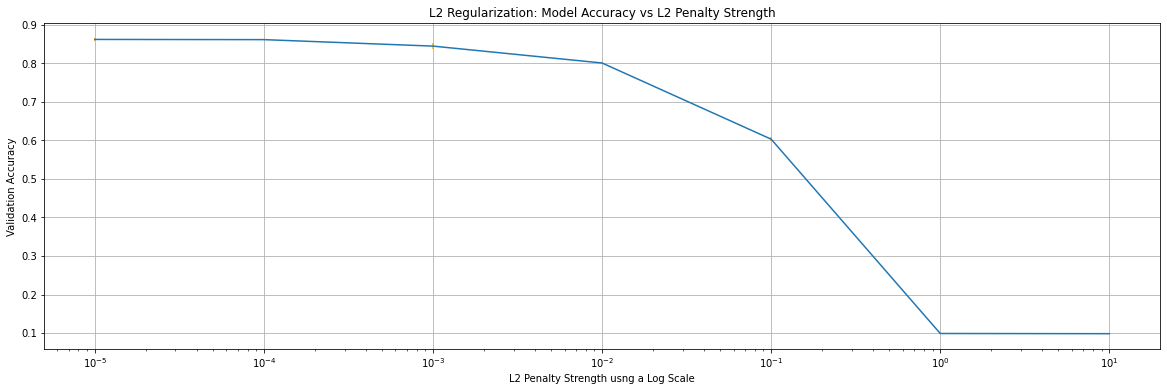

In [ ]:
# use the mean accuracy from the CV splits for determining best model score 
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

# move l2 penalty values outside of dictionary and into a list
param_values = [param_dict["reg_penalty"] for param_dict in params]

# plot accuracy vs l2_reg_penalty
plt.figure(figsize=(20,6))
plt.grid()

# this plot is using the std of the CV splits to plot error bars however those values are so small that they aren't visable
plt.errorbar(param_values, means, yerr=stds, ecolor="orange")
plt.xscale("log") # use a log scale for ease of reading, recall that l2_reg_penalty were in powers of 10 
plt.title("L2 Regularization: Model Accuracy vs L2 Penalty Strength")
plt.ylabel("Validation Accuracy", )
plt.xlabel("L2 Penalty Strength usng a Log Scale");

In [ ]:
grid_result.best_params_["reg_penalty"]

1e-05

### Observations

Write down some observations. What do you notice from the plot?

YOUR ANSWER HERE

The plot shows the validation accuracy as a function of the L2 penalty strength. We can see that as the L2 penalty strength increases, the validation accuracy decreases. This happens because a higher L2 penalty strength enforces stronger regularization to help prevent overfitting , but it may also result in underfitting the training data, leading to a lower validation accuracy.

The sweet spot for the L2 penalty strength in the plot is shown at the point where the validation accuracy is the highest, in this case 0.00001. This means that the model performs best when the L2 penalty strength is weaker.

The error bars in the plot indicate the standard deviation of the validation accuracy across the different cross-validation splits. It seems like there is some variability in the accuracy estimates for different L2 penalty strengths.


## Compare Weights between the Best Model and a Worse Model 

Next, we are going to compare the hidden layer weights between the best and worst performing model while taking note of the respective L2 penalty strengths.

In [ ]:
# get the best l2 penalty term 
best_lr_penalty = grid_result.best_params_["reg_penalty"]

# get the best trained model
#     a model that is wrapped in the KerasClassifier wrapper doesn't have a .get_weights() method.
#     So this is the workaround to generate a version of the model that does have a .get_weights() method
best_model = grid_result.best_estimator_.build_fn(Lp_reg=l2, reg_penalty=best_lr_penalty)

# get the weights from the best trained model 
best_weights = best_model.get_weights()

In [ ]:
# train a model using the l2_reg_penalty value that scored the lowest 
worse_l2_reg_penalty = 1.0

worse_model = build_complex_model(Lp_reg=l2, reg_penalty=worse_l2_reg_penalty)

# fit model 
worse_model.fit(X_train, y_train, epochs=1)

# get weights from worst performing model 
worse_weights = worse_model.get_weights()

2344/2344 [==============================] - 9s 3ms/step - loss: 13.2041 - accuracy: 0.1010


-----
## Understanding how Weights and Biases are stored

Let's take a minute to understand that`.get_weights()` returns a list with 8 elements (if you're using `build_complex_model`).

In [ ]:
len(best_weights)

8

There are **weights matrices and bias vectors between each layer** and we have 5 layers. The last 4 layers are composed of neurons. 

- Input
- Hidden 1
- Hidden 2
- Hidden 3
- Output 

So we should have a weight matrix and a bias vector from each neuron layer, <br>which accounts for $4 + 4 = 8$ elements in the list.


#### Index for Weight Matrices 
If you index for a weight matrix, you can see its shape and that they are indeed matrices. 

Notice how you can see the dims of the layers that the matrices are sandwiched between?

The input layer has 784 dims and hidden layer 1 has 500 neurons. <br>
So the first weight matrix should have a column of weights for each neuron; and each column has 784 weights.
Given this understanding, the numbers you see in the shapes of the weight and bias arrays should make sense. 

In [ ]:
# bewteen input and 1st hidden layer
best_weights[0].shape

(784, 500)

In [ ]:
# bewteen 1st and 2nd hidden layer
best_weights[2].shape

(500, 250)

In [ ]:
# bewteen 2nd and 3rd hidden layer
best_weights[4].shape

(250, 100)

In [ ]:
# bewteen 3rd hidden layer and output layer
best_weights[6].shape

(100, 10)

#### Index for the bias vectors

The shapes of the bias vectors should exactly match up the dims/nodes of each layer (excluding the input layer). 

In [ ]:
# for hidden layer 1 
best_weights[1].shape

(500,)

In [ ]:
# for hidden layer 2 
best_weights[3].shape

(250,)

In [ ]:
# for hidden layer 3
best_weights[5].shape

(100,)

In [ ]:
# for output layer
best_weights[7].shape

(10,)

-----

### Back to our Analysis of L2 space regularization (also known as Ridge)

To gauge the performance effect of L2 regularization, we'll compare the weights for the 1st hidden layer from the best and worst performing models from our hyperparameter search space, as well as with the initial weight values that are randomly sampled from the GlorotUniform distribution.

[**Check out the Keras docs for the Dense layer**](https://keras.io/api/layers/core_layers/dense/), you'll see that GlorotUniform is the default weight initializer. 

Read the docs to figure out how to get the weights from a Keras dense layer.
Also have a look at this helpful post on StackOverflow: [**How to view initialized weights (i.e. before training)?**](https://stackoverflow.com/questions/46798708/how-to-view-initialized-weights-i-e-before-training)


Before we compare weights, let's take note of the following. 

Both `best_weights[0]` or `worse_weights[0]` are matrices with shape `(784, 500)`. 

If we flatten them, then we get `784 * 500 = 392000` weights. What does this mean exactly?

Remember that we are working with the Fully Connected Feed-Forward model which looks something like this. 

![](https://pyimagesearch.com/wp-content/uploads/2016/08/simple_neural_network_header.jpg)

In Fully Connected neural network models, the outputs from a layer become the inputs for the next layer. Each output from a layer is passed as an input to all the nodes in next layer.<br>
Our input layer has $784$ output weights which are the pixel values in the image. Each neuron (or node) in hidden layer $1$ also has $784$ weights, one for each pixel input.  Hidden layer 1 has $500$ neurons. So the weights are conveniently represented as a **weights matrix** with $784$ rows (one row for each pixel in the input image) and $500$ columns (one column for each neuron in the layer). The $i$th column of the weights matrix holds the $784$ weights $\textbf{w}_{i}$ belonging to the $i$th neuron in the layer.

To keep our analysis simple, we are going to analyze only the weights corresponding to the first neuron in hidden layer $1$, whose weights $\textbf{w}_{1}$ are the first column of the weight matrix.  <br><br>

We will observe the effect of L2 regularization on neuron 1 in hidden layer 1.


In [ ]:
# YOUR CODE HERE

# index for the 1st column (784 entries) in the 1st hidden layer weights in best_weights and save to best_hidden_weights
best_hidden_weights = best_weights[0][0].flatten()
# index for the 1st column (784 entries) in the 1st hidden layer weights in worse_weights and save to worse_hidden_weights
worse_hidden_weights = worse_weights[0][0].flatten()

# Keras models randomly samples from the GlorotUniform distribution for the initial values of model weights 
# instantiate GlorotUniform and sample 784 weights and save to initial_weight_values
# Build a data frame with these 3 vectors as columns
initializer = GlorotUniform(seed=1234)
initial_weight_values = initializer(shape=(784, 1)).numpy().flatten()

# raise NotImplementedError()

In [ ]:
# move all weights to a dataframe for ease of analysis 
cols = ["best_hidden_weights", "worse_hidden_weights", "initial_weight_values"]
data = [best_hidden_weights, worse_hidden_weights, initial_weight_values]
df = pd.DataFrame(data=data).T
df.columns = cols

In [ ]:
# check out the statistics for each weight column 
df.describe()

,best_hidden_weights,worse_hidden_weights,initial_weight_values
count,500.000000,5.000000e+02,784.000000
mean,-0.000749,8.529865e-07,0.000399
std,0.039164,2.038480e-05,0.049670
min,-0.068040,-2.316647e-05,-0.087288
25%,-0.033711,-6.001742e-39,-0.040161
50%,-0.003729,1.902487e-40,-0.000564
75%,0.033736,6.281568e-39,0.043224
max,0.067054,4.551067e-04,0.087155


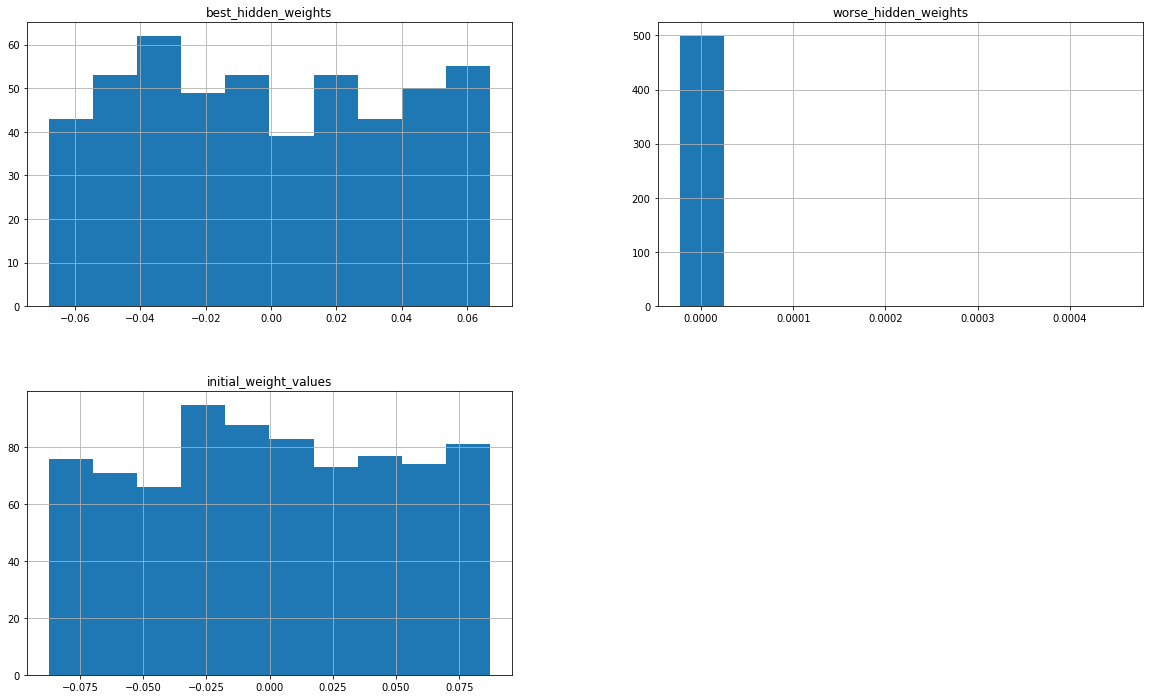

In [ ]:
# plot the distributions for each weight column 
df.hist(figsize=(20,12));

## Observations 

Take a look at the statistical table and the plots. Then answer the following questions. 

**How do the hidden layer weights from the best performing model compare to the initial weight values?**

YOUR ANSWER HERE

Both the best_hidden_weights and the worse_hidden_weights have a narrower range compared to the initial_weight_values. This is because the best_hidden_weights were reduced in size as a result of implementing L2 regularization. 

**What was the effect of using a small L2 penalty value (regularization constant)?**

YOUR ANSWER HERE

When using a small penalty value, L2 regularization reduced the weights to a value close to zero, but not all the way down to zero. This shrinking process was not excessively aggressive. 

**What was the effect of using a large L2 penalty value?**

YOUR ANSWER HERE

The utilization of a high penalty value in L2 regularization resulted in most weights being reduced to zero, indicating an excessively aggressive shrinking process.

**Given what you know about L2 regularization, are you surprised by these results?**

YOUR ANSWER HERE

No, I am not surprised by this outcome as L2 regularization is acknowledged for shrinking weight values, although typically not down to zero, in order to enhance model performance and avoid overfitting. However, if the penalty value surpasses 0.01, which is considered strong, the weight values will tend towards zero or approach zero, leading to a poorly performing model.

----

# Experiment 2: Identify the relationship between model performance and Max Norm Weight Constraint

![](https://qph.fs.quoracdn.net/main-qimg-9d0dbf8074761b541ba80543ddfc9f73.webp)

Recall from lecture that the **norm** of a vector is another word for the **length** of the vector.

`MaxNorm` weight constraint puts a limit on the norm of the weight vector.

The effect that Lp regularization and `MaxNorm` regularization have on the weights is similar, but they go about it in different ways. 

While Lp regularization (L1/Lasso and L2/Ridge) shrink the weight values by imposing constraints on their L1 and L2 norms, `MaxNorm` regularization shrinks the weight values by imposing a limit on the norm of a weight vector. Here's how it works: if an update would push the norm of a weight vector above MaxNorm, a scale factor is applied to all the weights so as to shrink the norm back to MaxNorm. 

In this experiment, we'll run another gridseach, similar to the one we ran for L2 regularization in the previous experiment. This time, we are going to gauge the effect of `MaxNorm` regularization on model performance and the distribution of the learned weights. As in the previous experiment, we will simplify our analysis by focusing on the weights for the first neuron in the first hidden layer.

Since we already built our model, we just need to update the `hyper_parameters` dictionary. 

In [ ]:
# build out our hyperparameter dictionary 
hyper_parameters = {
    
    "maxnorm_wc": np.linspace(0.5, 10.0, num=20), 
    # default is 1, in order to change it we must provide value here because we can't provide a parameter value for model.fit() directly when using gridsearch
    # protip: consider changing epochs to 1 if the gridsearche run-time are too long for you    
    "epochs": [1] 
}

hyper_parameters

{'maxnorm_wc': array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
         6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]), 'epochs': [1]}

In [ ]:
start=time()
# Create and run Grid Search
grid = GridSearchCV(estimator=model, 
                    param_grid=hyper_parameters, 
                    n_jobs=-2, 
                    verbose=1, 
                    cv=3)

grid_result = grid.fit(X_train, y_train)
end=time()

Fitting 3 folds for each of 20 candidates, totalling 60 fits
2344/2344 [==============================] - 10s 4ms/step - loss: 0.6002 - accuracy: 0.8171


In [ ]:
print("Gridsearch runtime {0:.3} mins".format( (end-start)/60 ))

Gridsearch runtime 12.7 mins


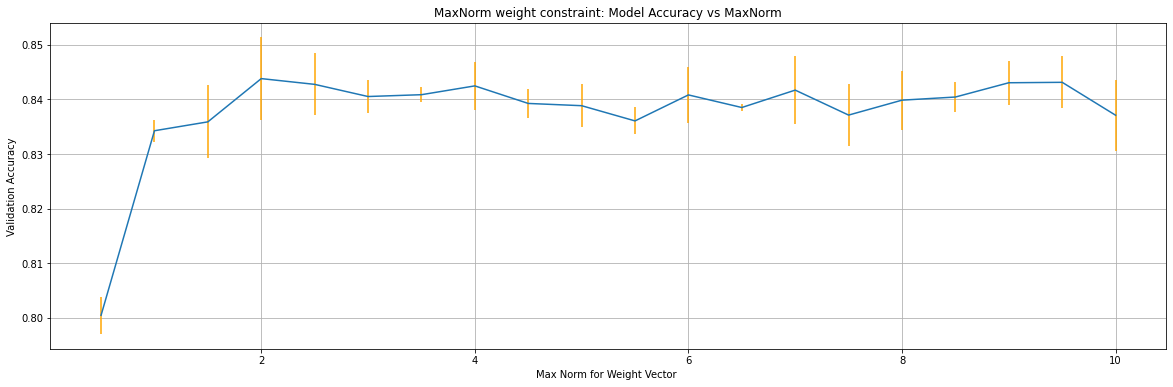

In [ ]:
# use the mean accuracy from the CV splits for determining best model score 
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

# move l2 penalty values outside of dictionary and into a list
param_values = [param_dict["maxnorm_wc"] for param_dict in params]

# plot accuracy vs l2_reg_penalty
plt.figure(figsize=(20,6))
plt.grid()
plt.errorbar(param_values, means, yerr=stds, ecolor="orange")
plt.title("MaxNorm weight constraint: Model Accuracy vs MaxNorm")
plt.ylabel("Validation Accuracy", )
plt.xlabel("Max Norm for Weight Vector ");

In [ ]:
# YOUR CODE HERE
# raise NotImplementedError()
# get the best value of max norm from grid and save to best_max_norm_val
best_max_norm_val = grid.best_params_["maxnorm_wc"]
# get the best trained model from grid and save to best_model
best_model = grid.best_estimator_.build_fn(maxnorm_wc=best_max_norm_val)
# get the weights from the best trained model and save to best_weights
best_weights = best_model.get_weights()

In [ ]:
best_max_norm_val

2.0

In [ ]:
# we can verify that the norm of our weights are indeed below the maximum allowed value 
np.linalg.norm(best_weights[0][0])

0.8865011

In [ ]:
# YOUR CODE HERE
# raise NotImplementedError()
# train a model using the max_norm_val value that scored the lowest 
worse_max_norm_val = 0.5
# build a model using build_complex_model and worse_max_norm_val and save it to worse_model
worse_model = build_complex_model(maxnorm_wc=worse_max_norm_val)
# fit model 
worse_model.fit(X_train, y_train, epochs=5)
# get weights from worse performing model 
worse_weights = worse_model.get_weights()

Epoch 1/5
2344/2344 [==============================] - 10s 4ms/step - loss: 0.6953 - accuracy: 0.7840
Epoch 2/5
2344/2344 [==============================] - 9s 4ms/step - loss: 0.5805 - accuracy: 0.8212
Epoch 3/5
2344/2344 [==============================] - 8s 4ms/step - loss: 0.5677 - accuracy: 0.8235
Epoch 4/5
2344/2344 [==============================] - 9s 4ms/step - loss: 0.5542 - accuracy: 0.8276
Epoch 5/5
2344/2344 [==============================] - 9s 4ms/step - loss: 0.5511 - accuracy: 0.8284


Sample the initial weights from the `Glorot Uniform Weight Initializer`, for comparison

In [ ]:
# YOUR CODE HERE
# raise NotImplementedError()
# index for the 1st hidden layer weights in best_weights and save to best_hidden_weights
best_hidden_weights = best_weights[0][0]
# index for the 1st hidden layer weights in worse_weights and save to worse_hidden_weights
worse_hidden_weights = worse_weights[0][0]
# Keras models randomly samples from the GlorotUniform distribution for the initial values of model weights 
# instantiate GlorotUniform and sample 500 weights and save to initial_weight_values
# hint: use shape=(1, 500)
initializer = GlorotUniform(seed=1234)
initial_weight_values = initializer(shape=(1, 500)).numpy()[0]

In [ ]:
# move all weights to a dataframe for ease of analysis 
cols = ["best_hidden_weights", "worse_hidden_weights", "initial_weight_values"]
data = [best_hidden_weights, worse_hidden_weights, initial_weight_values]
df_maxnorm= pd.DataFrame(data=data).T
df_maxnorm.columns = cols

In [ ]:
df_maxnorm.describe()

,best_hidden_weights,worse_hidden_weights,initial_weight_values
count,500.000000,5.000000e+02,500.000000
mean,0.000536,5.103974e-08,0.002079
std,0.039682,7.308202e-06,0.061731
min,-0.068324,-1.179792e-04,-0.109263
25%,-0.033594,-1.018734e-10,-0.047005
50%,0.000322,1.068164e-12,0.001182
75%,0.034870,4.133817e-10,0.055509
max,0.068340,5.117369e-05,0.109095


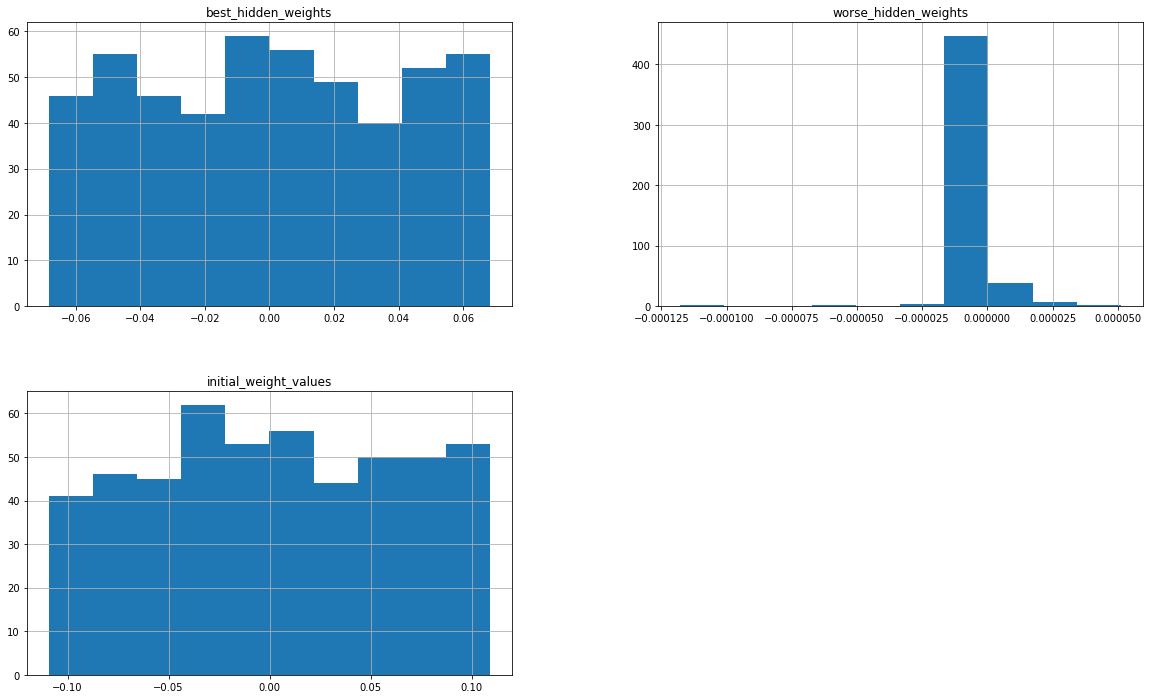

In [ ]:
# plot the distributions for each weight column 
df_maxnorm.hist(figsize=(20,12));

## Observations 

Take a look at the statistical table and the plots. Then answer the following questions. 

**How do the hidden layer weights from the best performing model compare to the initial weight values?**

YOUR ANSWER HERE

For both the best and worst models, the use of MaxNorm regularization has reduced the weight values from their initial values.

**What was the effect of using the weight constraint value in MaxNorm in the best performing model?**

YOUR ANSWER HERE

By using the appropriate weight constraint value for MaxNorm regularization, the weight values were reduced, but generally not to zero, indicating that the shrinking process was not excessively aggressive. This can be observed both in the plots and in the statistical tables, where the 75th percentile for best_hidden_weights has a value on the order of 0.01, while worse_hidden_weights has a value on the order of 10^-10.

**What was the effect of using the weight constraint value in MaxNorm in the worse performing model?**

YOUR ANSWER HERE

When an inappropriate weight constraint value was utilized for MaxNorm regularization, it caused a forceful reduction of weight values, leading to the majority of weights being brought extremely close to zero.

**Given what you know about MaxNorm regularization, are you surprised by these results?**

YOUR ANSWER HERE

MaxNorm regularization has a similar impact to Ridge regularization in terms of reducing the weight values, as a result of the norm value restriction. However, it is not apparent which weight constraint value will result in the optimal model performance.

-----
# Experiment 3: Identify the relationship between model performance and Dropout


![](https://miro.medium.com/max/981/1*EinUlWw1n8vbcLyT0zx4gw.png)

In the 3rd experiment, we will use gridsearch to see how varying the value of the the dropout probability affects model performance. 

Recall from lecture that dropout tends to perform best when used with `MaxNorm` regularization. Since this is the case, we will gridsearch both dropout probability and the weight constraint for `MaxNorm`. 

If interested, feel free to read (or just skim) through the original publication on [**Drop Out**](https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf). 

**Key Take aways:** 

1. During training, dropout will probabilistically "turn off" some neurons in the layer that dropout is implemented in. 
2. During inference (ie. making predictions on the test set) all neurons are used (i.e. no dropout is applied).
3. Dropout works best when used with MaxNorm


In [ ]:
# build out our hyperparameter dictionary 
hyper_parameters = {
    # for the sake of runtime, let's vary maxnorm_wc between 0.5 and 5.0
    "maxnorm_wc": np.linspace(0.5, 5, num=5),
    # take note that l1_reg_penalty values are in powers of 10 
    "dropout_prob": np.linspace(0.0, 0.6, num=5), 
    "epochs": [1] # default is 1, in order to change it we must provide value here because we can provide a parameter value for model.fit() directly when using gridsearch
}

hyper_parameters

{'maxnorm_wc': array([0.5  , 1.625, 2.75 , 3.875, 5.   ]),
 'dropout_prob': array([0.  , 0.15, 0.3 , 0.45, 0.6 ]),
 'epochs': [1]}

In [ ]:
start=time()
# Create and run Grid Search
grid = GridSearchCV(estimator=model, 
                    param_grid=hyper_parameters, 
                    n_jobs=-2, 
                    verbose=1, 
                    cv=3)

grid_result = grid.fit(X_train, y_train)
end=time()

Fitting 3 folds for each of 25 candidates, totalling 75 fits
2344/2344 [==============================] - 10s 4ms/step - loss: 0.6075 - accuracy: 0.8141


In [ ]:
print("Gridsearch runtime {0:.3} mins".format((end-start)/60))

Gridsearch runtime 16.0 mins


In [ ]:
# use the mean accuracy from the CV splits for determining best model score 
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

Since there are 2 independent hyperparameters which affect the validation accuracy (`dropout_prob` and `maxnorm_wc`), <br> 
we need a two-dimensional plot. A heat map will work. 

In [ ]:
dropout_prob_list = [  param_dict["dropout_prob"]  for param_dict in params]
maxnorm_wc_list = [  param_dict["maxnorm_wc"]  for param_dict in params]
data = [means, dropout_prob_list, maxnorm_wc_list ]

cols = ["val_acc", "dropout_prob", "maxnorm_wc"]
df_exp3 =pd.DataFrame(data=data).T
df_exp3.columns = cols
df_exp3.dropout_prob = df_exp3.dropout_prob.round(2)

# pivot dataframe in preparation for heat map
df_exp3 = df_exp3.pivot("maxnorm_wc", "dropout_prob", "val_acc")

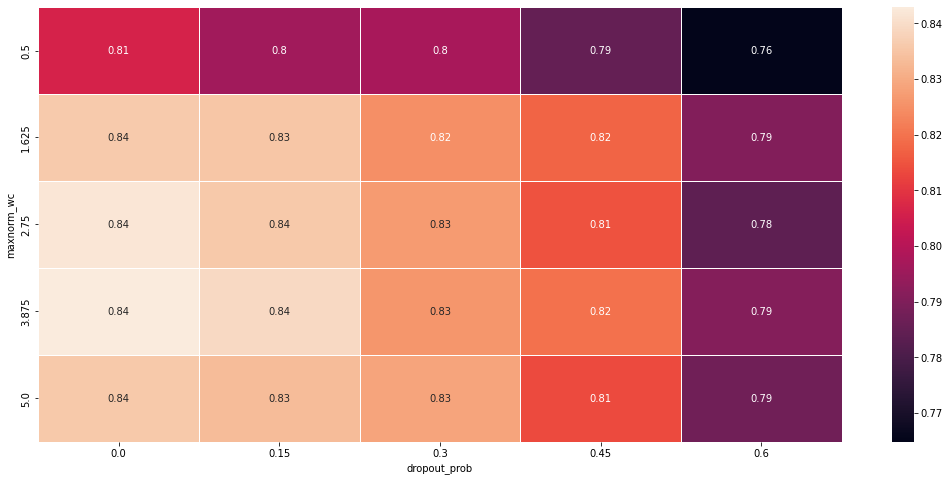

In [ ]:
# Draw a heatmap with the val_acc values in each cell
f, ax = plt.subplots(figsize=(18, 8))
sns.heatmap(df_exp3, annot=True,  linewidths=.5, ax=ax);

### Observations 

We can see the dropout probabilities in the horizontal axis and the `MaxNorm` weight constraint values in the vertical axis. The values in the cells are the validation accuracy that corresponds to a pair of regularization values.

Take a look at the heat map and answer the following questions. Note that depending on which model you used (the simple or complex one) your answers might be different from that of others. 

**What range of dropout probability values tend to produce the highest validation accuracy?**

YOUR ANSWER HERE

The heatmap shows that droput values between 0.0 and 0.3 tend to produce the highest validation accuracy.

**What range of maxnorm weight constraints tend to produce the highest validation accuracy?**

YOUR ANSWER HERE

The heatmap shows that most weight constraints values can lead to a high validation accuracy, it just depends on which dropout probability it's paired with.

**When taken together, what combinations of dropout probability and maxnorm weight constraints tend to produce the highest validation accuracy?**

YOUR ANSWER HERE

When taken together, the highest validation accuracies tend to be produced when the weight constraint values are between 1.62 and 5.0 and the dropout values are between 0.0. and 0.15.

**Do you think that using dropout was helpful in increasing model performance?**

YOUR ANSWER HERE

Based on the results from this experiment, it does seem that using dropout was helpful in increasing model performance. The results also suggest that dropout probability shouldn't be very aggressive in order to obtain the best results. so kept at or below 0.2.

_____

#Part 2: Model Deployment
# Experiment 4: Train, Save, and Load a Keras model

Let's get some practice with how to save and load trained Keras models 

For this experiment, review the section on Saving and Loading models from the guided project, then: 

- Build a model of your choosing
- Gridsearch the model with a method of your choosing
- Save the trained model to a file
- Load the trained model from the file
- Just as we did in the Guided Project, evaluate the loaded model using a test set and verify that the results of the loaded model match that of the original model that was saved.

In [ ]:
# YOUR CODE HERE
%%time

# set up checkpoint callback
checkpoint_filepath = "./weights_best.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=False)

my_model = KerasClassifier(build_fn=build_complex_model)

# build out our hyperparameter dictionary 
hyper_parameters = {
    "maxnorm_wc": np.linspace(1.5, 5, num=5),
    "dropout_prob": np.linspace(0.0, 0.2, num=5), 
    "epochs": [1] 
}

start=time()
# Create and run Grid Search
grid = GridSearchCV(estimator=my_model, 
                    param_grid=hyper_parameters, 
                    n_jobs=-2, 
                    verbose=1, 
                    cv=3)

grid_result = grid.fit(X_train, y_train,
                       epochs=1, 
                       validation_data=(X_test,y_test),
                       verbose=2,
                       callbacks=[checkpoint_callback])
end=time()

<timed exec>:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Fitting 3 folds for each of 25 candidates, totalling 75 fits

Epoch 1: saving model to ./weights_best.h5
1563/1563 - 9s - loss: 0.6523 - accuracy: 0.7999 - val_loss: 0.5206 - val_accuracy: 0.8422 - 9s/epoch - 6ms/step
782/782 [==============================] - 2s 2ms/step - loss: 0.5303 - accuracy: 0.8397

Epoch 1: saving model to ./weights_best.h5
1563/1563 - 8s - loss: 0.6445 - accuracy: 0.8011 - val_loss: 0.5265 - val_accuracy: 0.8411 - 8s/epoch - 5ms/step
782/782 [==============================] - 2s 2ms/step - loss: 0.5361 - accuracy: 0.8369

Epoch 1: saving model to ./weights_best.h5
1563/1563 - 8s - loss: 0.6474 - accuracy: 0.8023 - val_loss: 0.5197 - val_accuracy: 0.8416 - 8s/epoch - 5ms/step
782/782 [==============================] - 2s 2ms/step - loss: 0.5305 - accuracy: 0.8392

Epoch 1: saving model to ./weights_best.h5
1563/1563 - 9s - loss: 0.6503 - accuracy: 0.7994 - val_loss: 0.4914 - val_accuracy: 0.8508 - 9s/epoch - 6ms/step
782/782 [==============================] - 2

In [ ]:
print("Gridsearch runtime {0:.3} mins".format((end-start)/60))

Gridsearch runtime 16.8 mins


In [ ]:
# Evaluate the model
best_model = grid_result.best_estimator_
test_acc = best_model.score(X_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.4840 - accuracy: 0.8542


In [ ]:
# Load the saved model and the weights and biases
saved_my_model = tf.keras.models.load_model(checkpoint_filepath)

# Check that we retrieved the saved model architecture correctly
saved_my_model.summary()

# check that we get the original result using the saved weights
saved_my_model.evaluate(X_test, y_test)

Model: "sequential_249"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_996 (Dense)           (None, 500)               392500    
                                                                 
 re_lu_747 (ReLU)            (None, 500)               0         
                                                                 
 dropout_747 (Dropout)       (None, 500)               0         
                                                                 
 dense_997 (Dense)           (None, 250)               125250    
                                                                 
 re_lu_748 (ReLU)            (None, 250)               0         
                                                                 
 dropout_748 (Dropout)       (None, 250)               0         
                                                                 
 dense_998 (Dense)           (None, 100)            

[0.4840383529663086, 0.8541600108146667]